In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTestSinglePeriod import *
from backtest.BackTest import *
from backtest.percentile_portfolio import *

warnings.filterwarnings("ignore")

In [2]:
### universe setup ###
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, version=5, silent=False)

Setup R3000 universe
use existing binary file
0.706239 seconds


In [3]:
for t, table in univ.items():
    table.div_ratio = table.div_ratio.fillna(0)
filt_na(univ)

# construct all variants
univ_table = stack(univ)

In [4]:
from pdb import set_trace
def deps(univ_table, window, **kwargs):
    '''
    deps_t = eps_t / eps_{t-window} - 1
    '''
    name = 'deps'
    univ_table[name] = np.nan
    factor_dict = {}
    datelst = np.unique(univ_table['date'])

    def _deps_single_name(table):
        table['eps_lag'] = table['eps'].shift(window)
        table[name] = table['eps'] - table['eps_lag']
        return table
    
    univ_table = univ_table.groupby('ticker').apply(_deps_single_name)

    # set_trace()
    for t in datelst:
        table = univ_table.loc[univ_table.date == t, ['date', 'ticker', name]].copy()
        table.dropna(inplace = True)
        if type(t) == str:
            t = datetime.strptime(t, '%Y-%m-%d') #XXX this is a temporary fix
        factor_dict[t] = table
    return factor_dict


In [5]:
%%time
factors = {}
factors['deps'] = deps(univ_table, window=52)

CPU times: user 37.9 s, sys: 504 ms, total: 38.4 s
Wall time: 38.4 s


In [6]:
factor_names = list(factors.keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

In [7]:
### Filt the illiquid names within universe ###
print('Filt the untradables')
filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'volume', 1500000)

Filt the untradables


In [13]:
filt_byval(univ, 'div_ratio', 15, keep='below')

In [12]:
def filt_byval(univ, varname, thrd, keep='above'):
	'''
	filter out any element under varname that has value thrd or below
	'''
	datelst = sorted(univ.keys())
	N_T = len(datelst)

	for ti in range(N_T):
		t = datelst[ti]
		univ_ti = univ[t]
		idx_in = univ_ti[varname] > thrd
		if keep == 'below':
			# set_trace()    
			idx_in = ~idx_in
		univ[t] = univ_ti.ix[idx_in,:]        

In [15]:
factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1'])

In [16]:
# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Scale each factor
Winsorize with +/- 3 std
Done


In [17]:
datelst = sorted(univ.keys())
print(datelst[0], datelst[-1])
start_date = datetime(2012, 1, 1)
end_date = datetime(2016, 12, 31)

2010-10-05 00:00:00 2017-10-03 00:00:00


In [18]:
spcalc = PercentilePtflSpcalc(signal='deps', sel_range=[90, 100])
bt = BackTest(univ, factor_exp_mat, [start_date, end_date], spcalc)
ptfl_lst, pnl_lst = bt.calc_pnl()
bt.calc_pa()

CAGR :	 0.0801700226849
Volatility :	 0.195761106732
Sharpe :	 0.393941669235
Max_Drawdown :	 0.404436988091
Drawdown_Length :	 8


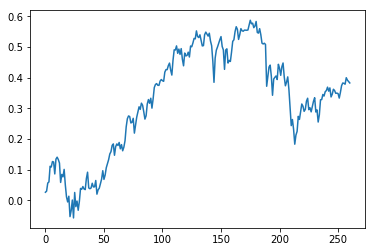

In [19]:
plt.plot(np.cumsum(pnl_lst.pnl))
plt.show()

In [20]:
%%time
from itertools import product
step = 5
ranges = [[i * step, (i + 1) * step] for i in range(100//step)]
daterange = [start_date, end_date]
config_iter = product(factor_names, ranges)
iter_result = {}
for f, g in config_iter:
    print(f,g)
    spcalc = PercentilePtflSpcalc(signal=f, sel_range=g, weighting='equal')
    bt = BackTest(univ, factor_exp_mat, daterange, spcalc)
    ptfl_lst, pnl_lst = bt.calc_pnl()
    k = f + '_' + str(g[0]) + '_' + str(g[1])
    iter_result[k] = (np.nanmean(pnl_lst.pnl), np.sqrt(np.nanvar(pnl_lst.pnl)))

deps [0, 5]
deps [5, 10]
deps [10, 15]
deps [15, 20]
deps [20, 25]
deps [25, 30]
deps [30, 35]
deps [35, 40]
deps [40, 45]
deps [45, 50]
deps [50, 55]
deps [55, 60]
deps [60, 65]
deps [65, 70]
deps [70, 75]
deps [75, 80]
deps [80, 85]
deps [85, 90]
deps [90, 95]
deps [95, 100]
CPU times: user 8min 40s, sys: 196 ms, total: 8min 40s
Wall time: 8min 40s


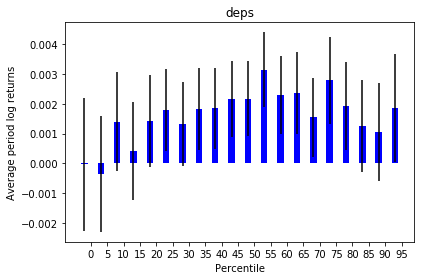

In [21]:
for n in factor_names:
    c = len(pnl_lst)
    x = [5*i for i in range(20)]
    y = [iter_result[n+'_'+str(i)+'_'+str(i+5)][0] for i in x]
    s = [iter_result[n+'_'+str(i)+'_'+str(i+5)][1] / np.sqrt(c) for i in x]
    
    # Here comes the plots
    bar_width = 2
    week = plt.bar(np.array(x), y, width=bar_width, yerr=s, color='b')

    plt.xlabel('Percentile')
    plt.ylabel('Average period log returns')
    plt.title(n)
    plt.xticks(np.array(x) + bar_width, x)
    plt.legend()

    plt.tight_layout()
    plt.show()